In [1]:
import pandas as pd
import numpy as np
import os

Read data

In [2]:
data_dir = 'news_extracted'

train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'), sep='\t')
val_df = pd.read_csv(os.path.join(data_dir, 'val.csv'), sep='\t')
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'), sep='\t')

train_df.head()

,ID,TITLE,CATEGORY
0,59266,Jennifer Lopez Drops F-Bomb Whilst Judging 'Am...,Entertainment
1,76495,"GRAINS-Corn, soybeans hit multi-month highs on...",Business
2,85490,Apple Loses Patent-Use Bid in $2 Billion Samsu...,Science and Technology
3,106,McDonald's Blames Weak Sales On Weather,Business
4,27243,George RR Martin Considering 'Game Of Thrones'...,Entertainment


Category distribution

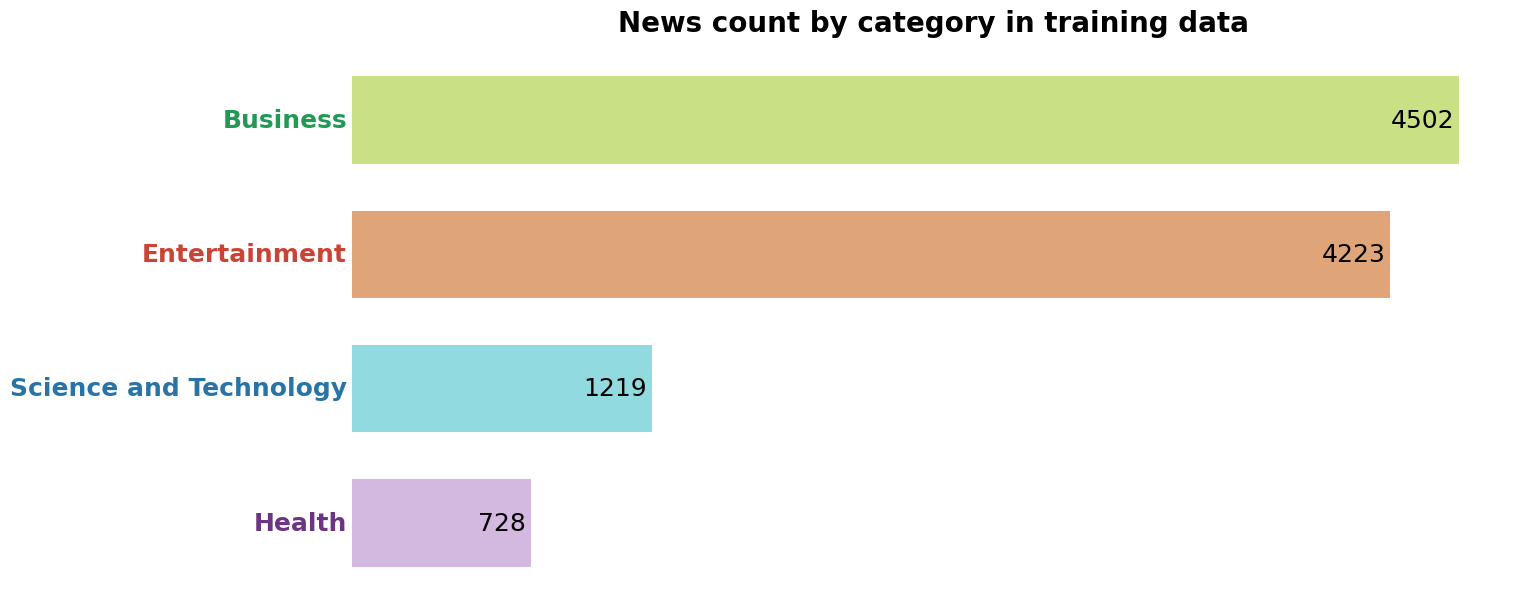

In [3]:
import matplotlib.pyplot as plt

colors = ['#D3B9DF', '#90DAE0', '#E0A479', '#CAE084']
colors_dark = ['#6C3483', '#2874A6', '#CB4335', '#229954']

category = pd.DataFrame(train_df['CATEGORY'].value_counts())
category.columns = ['count']
category = category.sort_values('count', axis=0, ascending=True)

fig = plt.figure(figsize=(15, 7))

plt.barh(width=category['count'], y=category.index, height=0.65,
         color=colors)

for i in range(len(category)):
    plt.text(s=f"{category.index[i]}",
             x=0 - 20, y=i, color = colors_dark[i],
             fontweight='bold', fontsize=18, va='center', ha='right')
    plt.text(s=f"{category['count'].values[i]}",
             x=category['count'].values[i] - 20, y=i, 
             fontweight='medium', fontsize=18, va='center', ha='right')

plt.xlabel('Count')
plt.ylabel('Category')
plt.title('News count by category in training data',
          fontweight='bold', fontsize=20, pad=15)

plt.axis('off')

plt.show()

Preprocess data

In [4]:
from modules.preprocessing import preprocess_text

train_df['TEXT'] = train_df['TITLE'].apply(preprocess_text)
val_df['TEXT'] = val_df['TITLE'].apply(preprocess_text)

train_df.head()

,ID,TITLE,CATEGORY,TEXT
0,59266,Jennifer Lopez Drops F-Bomb Whilst Judging 'Am...,Entertainment,jennifer lopez drop f bomb whilst judge americ...
1,76495,"GRAINS-Corn, soybeans hit multi-month highs on...",Business,grain corn soybeans hit multi month highs stoc...
2,85490,Apple Loses Patent-Use Bid in $2 Billion Samsu...,Science and Technology,apple lose patent use bid billion samsung trial
3,106,McDonald's Blames Weak Sales On Weather,Business,mcdonald s blame weak sales weather
4,27243,George RR Martin Considering 'Game Of Thrones'...,Entertainment,george rr martin consider game thrones movies


In [5]:
# vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=15000)
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

X_train = vectorizer.fit_transform(train_df['TEXT'])
X_val = vectorizer.transform(val_df['TEXT'])

encoder = LabelEncoder()
y_train = encoder.fit_transform(train_df['CATEGORY'])
y_val = encoder.transform(val_df['CATEGORY'])

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((10672, 60323), (1334, 60323), (10672,), (1334,))

In [6]:
class_weight = train_df['CATEGORY'].value_counts(normalize=True).to_dict()

class_weight = {encoder.transform([k])[0]: v for k, v in class_weight.items()}

# inverse the class weight to deal with imbalanced classes
class_weight = {k: 1/v for k, v in class_weight.items()}

class_weight

{0: 2.370501999111506,
 1: 2.5271134264740707,
 3: 8.754716981132075,
 2: 14.65934065934066}

In [72]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(class_weight=class_weight, loss='modified_huber', random_state=42)

model.fit(X_train, y_train)

SGDClassifier(class_weight={0: 2.370501999111506, 1: 2.5271134264740707,
                            2: 14.65934065934066, 3: 8.754716981132075},
              loss='modified_huber', random_state=42)

In [73]:
from sklearn.metrics import classification_report

y_val_pred = model.predict_proba(X_val)

# post processing
val_df['PROBA'] = y_val_pred.max(axis=1)
val_df['PRED'] = encoder.inverse_transform(y_val_pred.argmax(axis=1))

print('Validation data')
print(classification_report(val_df['CATEGORY'], val_df['PRED'], 
                            target_names=encoder.classes_, digits=4))
val_df

Validation data
                        precision    recall  f1-score   support

              Business     0.9344    0.9626    0.9483       562
         Entertainment     0.9682    0.9792    0.9736       528
                Health     0.9412    0.8791    0.9091        91
Science and Technology     0.8824    0.7843    0.8304       153

              accuracy                         0.9430      1334
             macro avg     0.9315    0.9013    0.9154      1334
          weighted avg     0.9422    0.9430    0.9421      1334



,ID,TITLE,CATEGORY,TEXT,PROBA,PRED
0,116674,Protecting Taxpayers from Abuse,Business,protect taxpayers abuse,0.298141,Business
1,238433,Ahead of the Bell: US Existing Home Sales,Business,ahead bell exist home sales,0.949312,Business
2,200295,Drone Almost Struck Airliner Over Florida in M...,Business,drone strike airliner florida march faa say,0.891916,Business
3,416866,Croatian Church Allegedly Blocks 'Game Of Thro...,Entertainment,croatian church allegedly block game thrones f...,0.930438,Entertainment
4,90754,RPT-US regulators to vote on final bank levera...,Business,rpt regulators vote final bank leverage rules,0.862142,Business
...,...,...,...,...,...,...
1329,215417,Carrie Fisher reveals she was asked to lose 35...,Entertainment,carrie fisher reveal ask lose pounds star wars...,0.928145,Entertainment
1330,93459,Kanye West slams Kim Kardashian's exes Kris Hu...,Entertainment,kanye west slams kim kardashian s exes kris hu...,1.000000,Entertainment
1331,229396,Elle Fanning Says What We're All Thinking Abou...,Entertainment,elle fanning say think angelina jolie,1.000000,Entertainment
1332,173507,Time Warner Beats Profit Estimates on 'Lego Mo...,Business,time warner beat profit estimates lego movie t...,0.928783,Business


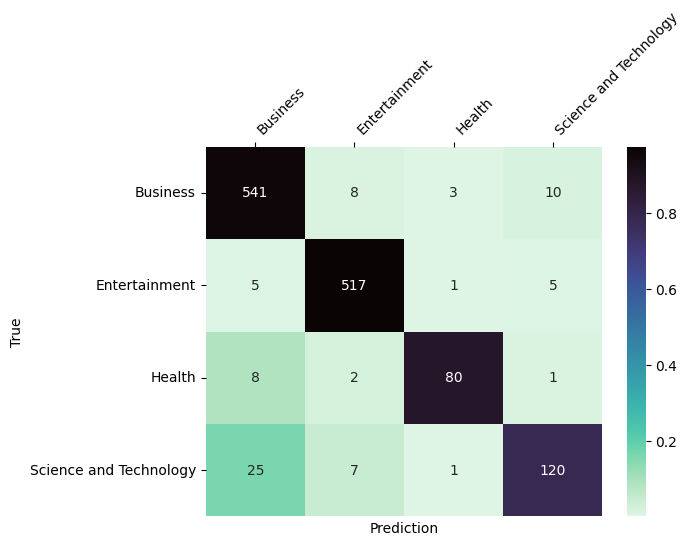

In [74]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(cm, labels, xrotation=0, yrotation=0):
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_norm, annot=cm, fmt='d', 
                robust=True, 
                cmap="mako_r",
                xticklabels=labels, yticklabels=labels)
    ax.xaxis.tick_top()
    if xrotation != 0:
        plt.xticks(rotation=xrotation, ha='left')
    else:
        plt.xticks(rotation=xrotation)
    plt.yticks(rotation=yrotation)
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()

cm_val = confusion_matrix(val_df['CATEGORY'], val_df['PRED'])
plot_confusion_matrix(cm_val, encoder.classes_, 
                      xrotation=45)

Test data
                        precision    recall  f1-score   support

              Business     0.9406    0.9556    0.9480       563
         Entertainment     0.9555    0.9754    0.9653       528
                Health     0.8295    0.8022    0.8156        91
Science and Technology     0.8741    0.7763    0.8223       152

              accuracy                         0.9325      1334
             macro avg     0.8999    0.8774    0.8878      1334
          weighted avg     0.9313    0.9325    0.9315      1334



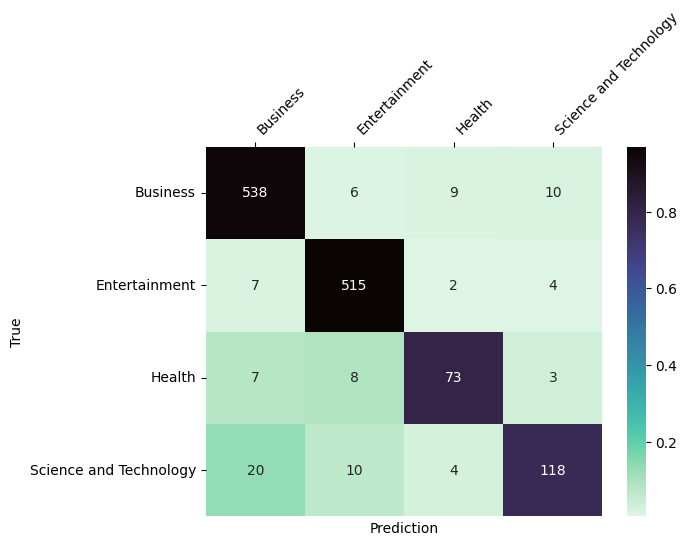

In [75]:
# test
test_df['TEXT'] = test_df['TITLE'].apply(preprocess_text)

X_test = vectorizer.transform(test_df['TEXT'])
y_test = encoder.transform(test_df['CATEGORY'])

y_test_pred = model.predict_proba(X_test)

test_df['PROBA'] = y_test_pred.max(axis=1)
test_df['PRED'] = encoder.inverse_transform(y_test_pred.argmax(axis=1))

print('Test data')
print(classification_report(test_df['CATEGORY'], test_df['PRED'], 
                            target_names=encoder.classes_, digits=4))

cm_test = confusion_matrix(test_df['CATEGORY'], test_df['PRED'])
plot_confusion_matrix(cm_test, encoder.classes_,  xrotation=45)

In [76]:
test_df.loc[test_df['CATEGORY'] != test_df['PRED']].sort_values('PROBA', ascending=False)

,ID,TITLE,CATEGORY,TEXT,PROBA,PRED
1021,93208,PRESS DIGEST - Hong Kong - April 8,Entertainment,press digest hong kong april,0.985389,Business
920,294035,Same engineer designed switches on 5.95 millio...,Business,engineer design switches million recall gm cars,0.914005,Science and Technology
663,378634,The coolest cooler ever: Ice box contains all ...,Science and Technology,coolest cooler ice box contain ingredients party,0.858586,Entertainment
837,170460,Mother's Day and Birthdays: A Wish for Young W...,Health,mother s day birthdays wish young women,0.843730,Entertainment
304,212174,Jill Abramson Backs Out Of Brandeis Commenceme...,Business,jill abramson back brandeis commencement cerem...,0.834290,Entertainment
...,...,...,...,...,...,...
1192,269471,Federal Agents Just Brought Down the World's W...,Science and Technology,federal agents bring world s worst botnet,0.342757,Entertainment
511,286181,Amazon under investigation after worker was cr...,Business,amazon investigation worker crush death huge,0.336032,Health
776,359167,Stressed at work? Meditating really does work ...,Health,stress work meditate work ll difference,0.335694,Science and Technology
516,50245,The soberphone app for alcoholics can set off ...,Health,soberphone app alcoholics set alarm stray close,0.334465,Business


In [77]:
# save model
import joblib

if not os.path.exists('model'):
    os.makedirs('model')

joblib.dump(model, 'model/classifier.pkl')
joblib.dump(vectorizer, 'model/vectorizer.pkl')
joblib.dump(encoder, 'model/label_encoder.pkl')

['model/label_encoder.pkl']